# Systematic Literature Review DX in Shipping - Concept Trends

Note: We can only do thematic analysis on title, since for the abstract we have inverted abstract and we are not capable of properly rebulding it

In [3]:
#!pip install spacy

In [4]:
#!python -m spacy download en_core_web_md

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from collections import Counter

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokens import DocBin

from gensim import corpora
from gensim.models import LdaModel
from sklearn.feature_extraction.text import TfidfVectorizer

from transformers import BertTokenizer, BertModel
import torch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Read the DB in

In [12]:
# Read in the file
#lit = pd.read_csv('C:/projects/dx_in_shipping/openalex_data_final.csv')
lit = pd.read_csv('./openalex_data.csv',low_memory=False)

In [79]:
# This cell is useful to check columns in the db. To be used only after having loaded the pandas df
substring = 'concepts'
# # List all column names containing the substring using list comprehension
test = [k for k in lit.columns if substring in k]
print(test)

['concepts_0_id', 'concepts_0_wikidata', 'concepts_0_display_name', 'concepts_0_level', 'concepts_0_score', 'concepts_1_id', 'concepts_1_wikidata', 'concepts_1_display_name', 'concepts_1_level', 'concepts_1_score', 'concepts_2_id', 'concepts_2_wikidata', 'concepts_2_display_name', 'concepts_2_level', 'concepts_2_score', 'concepts_3_id', 'concepts_3_wikidata', 'concepts_3_display_name', 'concepts_3_level', 'concepts_3_score', 'concepts_4_id', 'concepts_4_wikidata', 'concepts_4_display_name', 'concepts_4_level', 'concepts_4_score', 'concepts_5_id', 'concepts_5_wikidata', 'concepts_5_display_name', 'concepts_5_level', 'concepts_5_score', 'concepts_6_id', 'concepts_6_wikidata', 'concepts_6_display_name', 'concepts_6_level', 'concepts_6_score', 'concepts_7_id', 'concepts_7_wikidata', 'concepts_7_display_name', 'concepts_7_level', 'concepts_7_score', 'concepts_8_id', 'concepts_8_wikidata', 'concepts_8_display_name', 'concepts_8_level', 'concepts_8_score', 'concepts_9_id', 'concepts_9_wikidat

In [18]:
# This cell is useful to check columns in the db. To be used only after having loaded the pandas df
substring = 'concepts'
substring2 = '_display_name'
# # List all column names containing the substring using list comprehension
matching_columns = [k for k in lit.columns if substring in k and substring2 in k]
print(matching_columns)
# #lit['title']

['concepts_0_display_name', 'concepts_1_display_name', 'concepts_2_display_name', 'concepts_3_display_name', 'concepts_4_display_name', 'concepts_5_display_name', 'concepts_6_display_name', 'concepts_7_display_name', 'concepts_8_display_name', 'concepts_9_display_name', 'concepts_10_display_name', 'concepts_11_display_name', 'concepts_12_display_name', 'concepts_13_display_name', 'concepts_14_display_name', 'concepts_15_display_name', 'concepts_16_display_name', 'concepts_17_display_name', 'concepts_18_display_name', 'concepts_19_display_name', 'concepts_20_display_name', 'concepts_21_display_name', 'concepts_22_display_name', 'concepts_23_display_name', 'concepts_24_display_name', 'concepts_25_display_name', 'concepts_26_display_name', 'concepts_27_display_name', 'concepts_28_display_name', 'concepts_29_display_name', 'concepts_30_display_name', 'concepts_31_display_name', 'concepts_32_display_name', 'concepts_33_display_name', 'concepts_34_display_name']


In [105]:
# we want to get now a lit['year'] with the proper publication year and a lit['concepts'] with list of concepts for that paper
concept_list = {}
limit_to_concept_level = 2 # we only take concepts with level this or above (possible values, 0,1,2,3,4,5)
p_year = {}
for index, row in lit.iterrows():
    p_year[row['id']] = pd.to_datetime(row['publication_date']).year 
    for c in matching_columns:        
        if not pd.isnull(row[c]):
            c_level = row[c.replace('_display_name', '_level')]        
            if (c_level >= limit_to_concept_level):
                if not row['id'] in concept_list:                
                    concept_list[row['id']] = []
                    concept_list[row['id']].append(row[c])
                else:
                    concept_list[row['id']].append(row[c])

# # Normalize concepts (split semicolon-separated strings into lists if necessary)
# lit['concepts'] = lit['concepts'].str.lower().str.split(';')  # Adjust delimiter as needed

# # Remove NaN or empty concept entries
# lit = lit[lit['concepts'].notna()]

In [107]:
# prepare new dataset
# Ensure both dictionaries share the same keys
common_ids = set(p_year.keys()) & set(concept_list.keys())

# Create the DataFrame
data = pd.DataFrame({
    'id': list(common_ids),
    'year': [p_year[id] for id in common_ids],
    'concepts': [concept_list[id] for id in common_ids]
})

In [109]:
data

,id,year,concepts
0,https://openalex.org/W4388741155,2023,"[Multihoming, Blockchain, Profitability index,..."
1,https://openalex.org/W3170579996,2021,"[Spoofing attack, Vulnerability (computing), S..."
2,https://openalex.org/W3203599577,2021,"[Sustainability, Adaptation (eye), Critical su..."
3,https://openalex.org/W4392528550,2024,"[Automatic Identification System, Trajectory, ..."
4,https://openalex.org/W4396841349,2024,"[Multimodal transport, Mainland China, China, ..."
...,...,...,...
2206,https://openalex.org/W4392388797,2024,"[Hydrology (agriculture), Quarter (Canadian co..."
2207,https://openalex.org/W4385697121,2023,"[Port (circuit theory), Air quality index, Cli..."
2208,https://openalex.org/W4296125434,2022,"[Flagging, Hull, Domain (mathematical analysis)]"
2209,https://openalex.org/W4282570835,2022,"[Random forest, Artificial neural network, Sup..."


In [111]:
# Frequency analysis of topics

# Aggregate concepts by year
concepts_by_year = data.groupby('year')['concepts'].sum()  # Combine concept lists by year

# Count concept frequencies for each year
concept_trends = pd.DataFrame([
    Counter(year_concepts) for year_concepts in concepts_by_year
]).fillna(0)

# Add years as a column
concept_trends.index = concepts_by_year.index  # Year as the index
concept_trends.reset_index(inplace=True)
concept_trends.rename(columns={'index': 'Year'}, inplace=True)

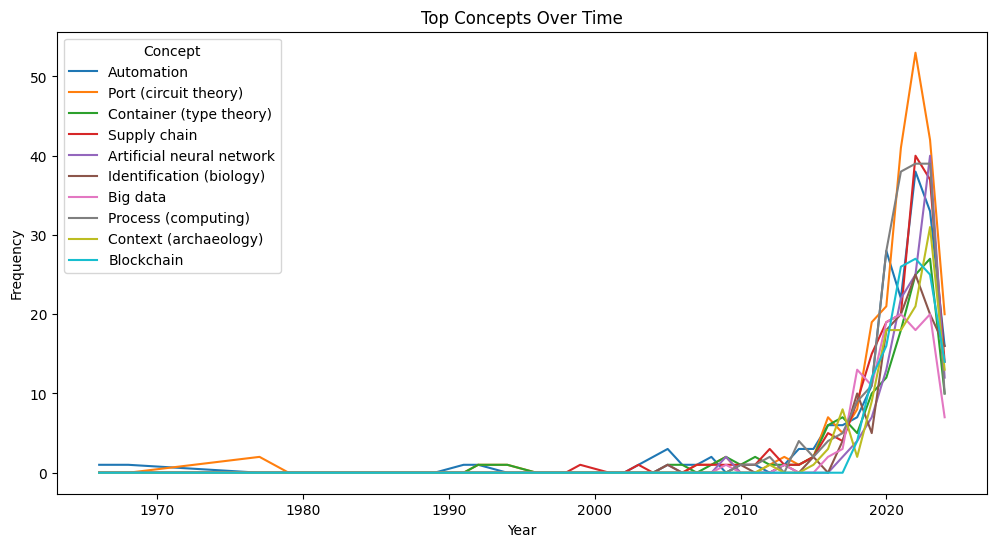

In [119]:
# Get the top N concepts overall
top_concepts = concept_trends.iloc[:, 1:].sum().sort_values(ascending=False).head(10).index

# Melt data for plotting
trend_melted = concept_trends.melt('year', var_name='Concept', value_name='Frequency')
trend_melted = trend_melted[trend_melted['Concept'].isin(top_concepts)]  # Filter top concepts

# Plot trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_melted, x='year', y='Frequency', hue='Concept')
plt.title('Top Concepts Over Time')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(title='Concept')
plt.show()

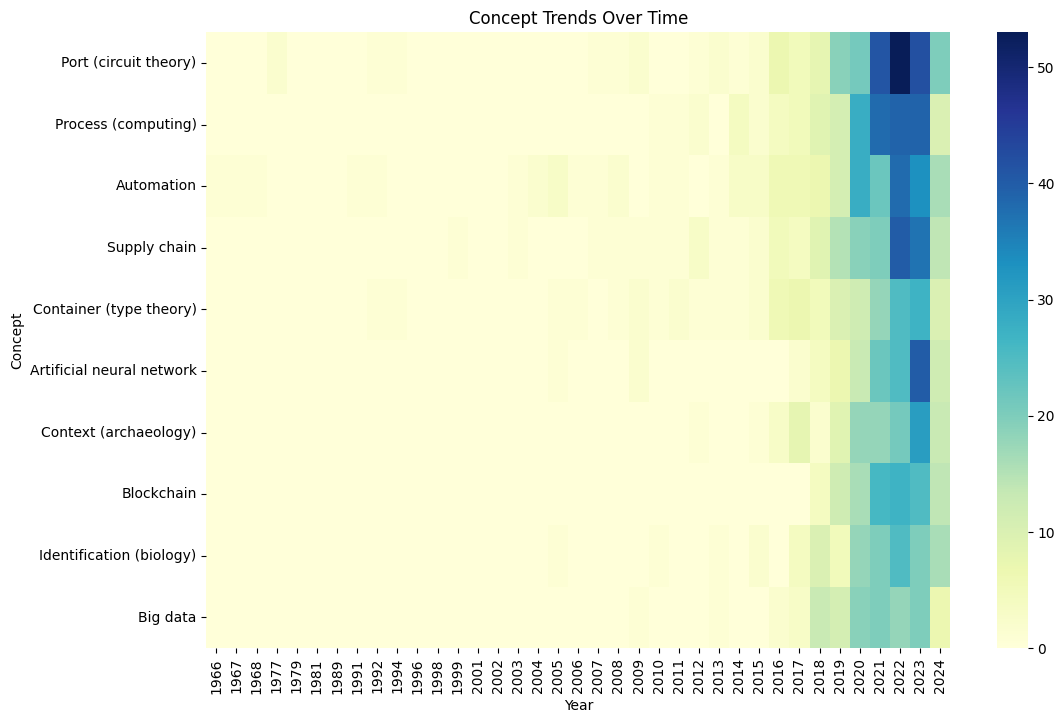

In [121]:
# Filter only top concepts
heatmap_data = concept_trends[['year'] + list(top_concepts)].set_index('year')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.T, cmap='YlGnBu', annot=False)
plt.title("Concept Trends Over Time")
plt.ylabel("Concept")
plt.xlabel("Year")
plt.show()